In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [2]:
path0='C:/Users/jisma/altamira/kawesqar24'
path='..'

# Preprocess LHS simulation results

In [38]:
result_files = [file for file in os.listdir(path0+'/results') if 'stat' in file]
Nexp = len(result_files)
print('Number of experiments:', Nexp)

Number of experiments: 1001


In [39]:
df0=pd.read_csv(path0+'/results/'+result_files[0], sep=',', skiprows=range(6)).head(1)
model_parameters=df0.columns[:5].to_list()
print('Model parameters:')
for p in model_parameters: print(p) 
model_varables=df0.columns[5:].to_list()
print('\nModel variables:')
for v in model_varables: print(v)

Model parameters:
mu-logistic-whaling-success
whaling-harm-prob
theta
mutation-prob
n-people

Model variables:
[step]
(mean) average-whale-hunt
(std) average-whale-hunt
(mean) average-help-others
(std) average-help-others
(mean) average-fitness
(std) average-fitness
(mean) average-resources
(std) average-resources
(mean) average-social-capital
(std) average-social-capital
(mean) average-disabled
(std) average-disabled


In [81]:
Nsteps = 1000 # Number of the last steps to be considered in the analysis

In [101]:
# stationary state results
dfr=df0.iloc[:1,:].copy() # pd.DataFrame(columns=df0.columns) # concatenation with empty is deprecated in Pandas
dfr['experiment']=None
for file in result_files:
    df=pd.read_csv(path0+'/results/'+file, sep=',', skiprows=range(6)).tail(Nsteps)
    df['experiment']=int(re.findall(r'\d+', file)[0])
    dfr=pd.concat([dfr,df],axis=0,ignore_index=True)
dfr=dfr.iloc[1:].reset_index(drop=True) # remove the first row
dfr.to_csv(path+'/results/stationary_state.csv',index=False)

# Checking stationarity
Check if simulations have reached a stationary state in the last 1000 tick

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

In [13]:
dfr=pd.read_csv(path+'/results/stationary_state.csv')

In [14]:
stationary_test = pd.DataFrame(columns=['experiment', 'ADF Statistic', 'ADF p-value', 
                                        'KPSS Statistic', 'KPSS p-value'])
stationary_test['experiment'] = dfr['experiment'].unique()
for exp in stationary_test['experiment']:
    time_series = dfr[dfr['experiment'] == exp]['(mean) average-whale-hunt'].tail(1000)
    with warnings.catch_warnings(record=True) as w:
        adf_result = adfuller(time_series)
        kpss_result = kpss(time_series, regression='c')
        stationary_test.loc[exp, 'ADF Statistic'] = adf_result[0]
        stationary_test.loc[exp, 'ADF p-value'] = adf_result[1]
        stationary_test.loc[exp, 'KPSS Statistic'] = kpss_result[0]
        stationary_test.loc[exp, 'KPSS p-value'] = kpss_result[1]

In [15]:
print('Non-stationarity test results (ADF):')
print(stationary_test[stationary_test['ADF p-value'] > 0.05].shape[0], 'non-stationary experiments')
print('Non-stationarity test results (KPSS):')
print(stationary_test[stationary_test['KPSS p-value'] < 0.05].shape[0], 'non-stationary experiments')
print('Non-stationarity test results in both statistics:')
print(stationary_test[(stationary_test['ADF p-value'] > 0.05) & (stationary_test['KPSS p-value'] < 0.05)].shape[0], 'non-stationary experiments')

Non-stationarity test results (ADF):
8 non-stationary experiments
Non-stationarity test results (KPSS):
147 non-stationary experiments
Non-stationarity test results in both statistics:
8 non-stationary experiments


In [16]:
stationary_test['stat']=1
for exp in stationary_test[(stationary_test['ADF p-value'] > 0.05) & (stationary_test['KPSS p-value'] < 0.05)].index:
    stationary_test.loc[exp,'stat']=0
stationary_test.to_csv(path+'/results/stationary_test.csv',index=False)

# Random Forest parameter importance analysis

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from sklearn.multioutput import MultiOutputRegressor

In [18]:
# Simulation results for the last 1000 steps
dfr=pd.read_csv(path+'/results/stationary_state.csv')
stationary_test= pd.read_csv(path+'/results/stationary_test.csv')
dfr.shape[0]

1000000

In [31]:
# Remove non-stationary experiments
dfr=dfr[dfr['experiment'].isin(stationary_test.loc[stationary_test['stat']==1,'experiment'])]
dfr.shape[0]

992000

In [32]:
for i in range(len(dfr.columns)): print(i, dfr.columns[i])

0 mu-logistic-whaling-success
1 whaling-harm-prob
2 theta
3 mutation-prob
4 n-people
5 [step]
6 (mean) average-whale-hunt
7 (std) average-whale-hunt
8 (mean) average-help-others
9 (std) average-help-others
10 (mean) average-fitness
11 (std) average-fitness
12 (mean) average-resources
13 (std) average-resources
14 (mean) average-social-capital
15 (std) average-social-capital
16 (mean) average-disabled
17 (std) average-disabled
18 experiment


In [33]:
X = dfr.iloc[:, :4].values  # Model paramter (excecpt n-people)
y = dfr.iloc[:, [6,8]].values  # Output variables: '(mean) average-whale-hunt' and '(mean) average-help-others'
groups = dfr.iloc[:, -1].values  # 'Experiment' is used for stratification

In [34]:
# Random Forest model
seed=1234
base_model = RandomForestRegressor(n_estimators=100, random_state=seed)
model = MultiOutputRegressor(base_model)

# Stratified 5-fold cross-validation
gkf = GroupKFold(n_splits=5)
scores = cross_val_score(model, X, y, groups=groups, cv=gkf)
print('Cross-validation scores:', scores)
print('Average cross-validation score:', np.mean(scores))

Cross-validation scores: [0.89068283 0.90678494 0.87107624 0.85159981 0.86747727]
Average cross-validation score: 0.8775242194426639


In [35]:
# Parameter importance by 5-fold cross-validation
parameter_importances = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    base_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    fold_importances = [est.feature_importances_ for est in model.estimators_]
    parameter_importances.append(fold_importances)


In [46]:
# Parameter importance for (mean) average-whale-hunt
df_whale_hunt=pd.DataFrame([x[0] for x in parameter_importances],columns=model_parameters[:-1])
df_whale_hunt.to_csv(path+'/results/parameter_importance_whale_hunt.csv',index=False)
df_whale_hunt.mean().sort_values(ascending=False)

theta                          0.512386
whaling-harm-prob              0.393111
mu-logistic-whaling-success    0.068157
mutation-prob                  0.026347
dtype: float64

In [47]:
# Parameter importance for (mean) average-help-others
df_help_others=pd.DataFrame([x[1] for x in parameter_importances],columns=model_parameters[:-1])
df_help_others.to_csv(path+'/results/parameter_importance_help_others.csv',index=False)
df_help_others.mean().sort_values(ascending=False)

theta                          0.752644
whaling-harm-prob              0.214619
mu-logistic-whaling-success    0.016669
mutation-prob                  0.016067
dtype: float64

# Explainable Boosting Machine

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import pickle

In [4]:
# Simulation results for the last 1000 steps
dfr=pd.read_csv(path+'/results/stationary_state.csv')
stationary_test= pd.read_csv(path+'/results/stationary_test.csv')
dfr.shape[0]

1000000

In [5]:
# Remove non-stationary experiments
dfr=dfr[dfr['experiment'].isin(stationary_test.loc[stationary_test['stat']==1,'experiment'])]
dfr.shape[0]

992000

In [6]:
for i in range(len(dfr.columns)): print(i, dfr.columns[i])

0 mu-logistic-whaling-success
1 whaling-harm-prob
2 theta
3 mutation-prob
4 n-people
5 [step]
6 (mean) average-whale-hunt
7 (std) average-whale-hunt
8 (mean) average-help-others
9 (std) average-help-others
10 (mean) average-fitness
11 (std) average-fitness
12 (mean) average-resources
13 (std) average-resources
14 (mean) average-social-capital
15 (std) average-social-capital
16 (mean) average-disabled
17 (std) average-disabled
18 experiment


## EBM for '(mean) average-whale-hunt'

In [16]:
import warnings

In [52]:
seed=1234

# Simulation data (the last 1000 steps that passed the stationary test)
X = dfr.iloc[:,:4].values  # Model paramter (excecpt n-people)
y = dfr.iloc[:, 6].values  # Output variables: '(mean) average-whale-hunt' 

model=ExplainableBoostingRegressor(random_state=seed)

# Train the model
model.fit(X,y)
print('MSE: %0.4f' % mean_squared_error(y,model.predict(X)))

MSE: 0.0032


In [53]:
# Save model
pickle.dump(model, open('./ebm_average_whale_hunt.pkl', 'wb'))

In [7]:
# Load model
model=pickle.load(open('./ebm_average_whale_hunt.pkl', 'rb'))

In [8]:
feature_names={'feature_0000':'mu-logistic-whaling-success',
 'feature_0001':'whaling-harm-prob',
 'feature_0002':'theta',
 'feature_0003':'mutation-prob'}

In [9]:
# Change feature names
names=model.explain_global().feature_names
for fn in feature_names.keys():
    for i in range(len(names)):
        if fn in names[i]:
            names[i]=names[i].replace(fn,feature_names[fn])
names

['mu-logistic-whaling-success',
 'whaling-harm-prob',
 'theta',
 'mutation-prob',
 'mu-logistic-whaling-success & whaling-harm-prob',
 'mu-logistic-whaling-success & theta',
 'whaling-harm-prob & theta',
 'theta & mutation-prob']

In [10]:
# Global interpretation
ebm_global = model.explain_global()

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

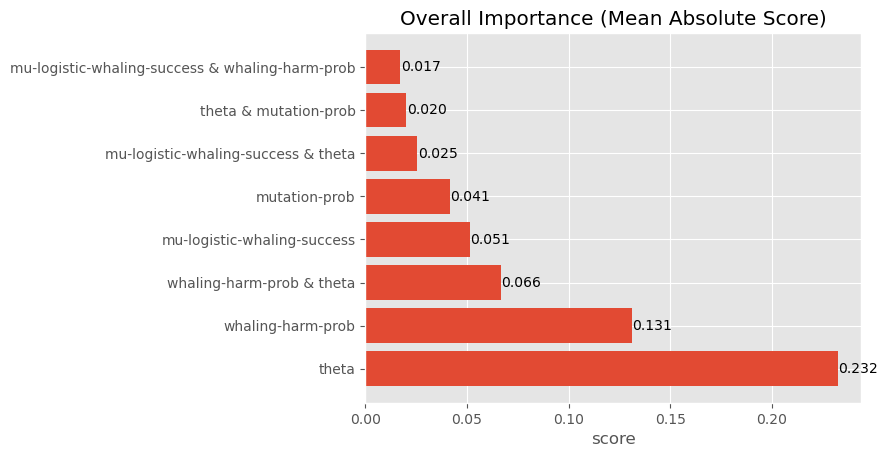

In [12]:
# Global Parameter importance
df=pd.DataFrame(ebm_global.data()) 
df['names']=names
df.sort_values(by='scores',ascending=False,inplace=True) # sorted by scores
fig, ax = plt.subplots()
y_pos = np.arange(df.shape[0])
ax.barh(y_pos, df['scores'], align='center')
for i, v in enumerate(df['scores']):
    ax.text(v + 0.02, i, '%0.3f'%v, va='center', ha='right')

ax.set_yticks(y_pos, labels=df['names'])
#ax.invert_yaxis()  
ax.set_xlabel('score')
ax.set_title('Overall Importance (Mean Absolute Score)')
plt.show()

In [60]:
# Plot function of the contribution of each predictor
def plot_individual_variable(name,dt,export=False):
    # Score-variable plot
    x_vals = dt.get('names')[1:]
    y_vals = dt.get('scores')
    y_hi = dt.get('upper_bounds')
    y_lo = dt.get('lower_bounds')

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x_vals, y_vals)
    ax.fill_between(x_vals, y_lo, y_hi, color='gray', alpha=0.5, label='upper-lower bounds')
    ax.set_ylabel('score')
    ax.set_xlabel(name)
    #ax.set_title(name,fontsize=12)
    ax.set(xlim=(0,0.1) if name=='mutation-prob' else (0,1))
    if export:
        fig.write_image(path + '.figures/ebr_' + name + '.pdf')
    fig.show()

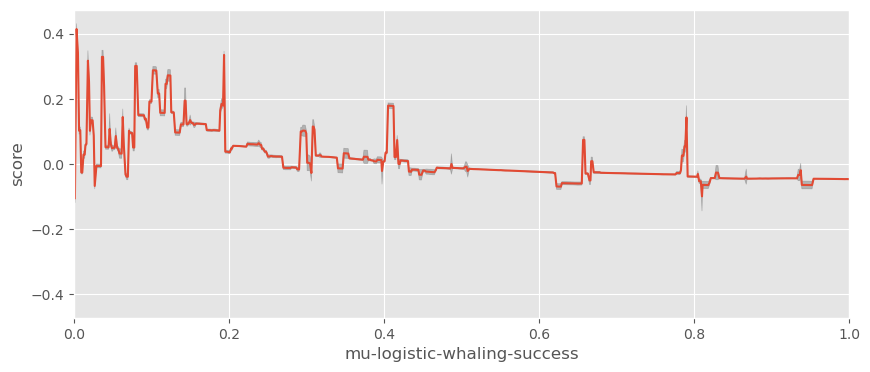

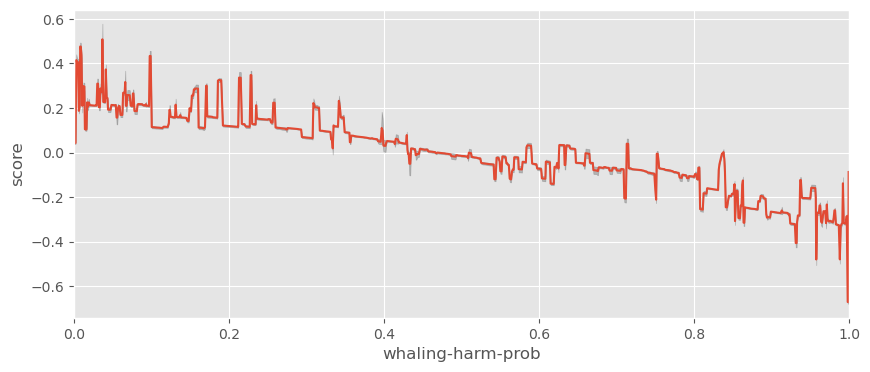

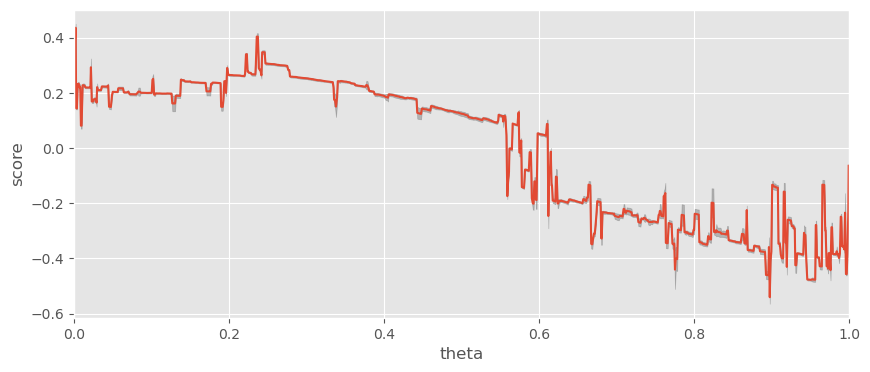

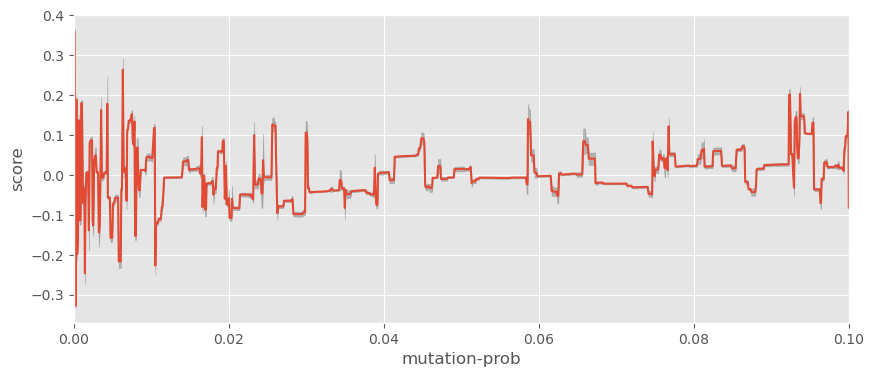

In [61]:
with warnings.catch_warnings(record=True) as w:
    for i,v in enumerate(names[:4]):
        plot_individual_variable(names[i],ebm_global.data(i))

In [62]:
import plotly.graph_objs as go

In [47]:
def plot_interaction(name1,name2,dt,export=False):
    # Score-variable plot
    bin_labels_left = dt.get('left_names')
    bin_labels_right = dt.get('right_names')
    bin_vals = dt.get('scores')
    bin_vals =bin_vals.T

    fig = go.Figure(
        go.Heatmap(z=bin_vals, x=bin_labels_left, y=bin_labels_right,
               colorscale = 'Inferno',textfont_size=12))
    fig.update_layout(autosize=False, width=600, height=600,
            xaxis=dict(title_text=name1),yaxis=dict(title_text=name2))
    if export:
        fig.write_image(path + '.figures/ebr_' + name1 + '_' + name2 + '.pdf')
    fig.show()

In [56]:
for i,v in enumerate(names[4:]):
    plot_interaction(v.split(' & ')[0],v.split(' & ')[1],ebm_global.data(i+4))

In [65]:
# 'interpret' package visualization 
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
show(model.explain_global())

# Clustering analysis

In [66]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
plt.style.use('ggplot')

In [67]:
dfr=pd.read_csv(path+'/results/stationary_state.csv')
stationary_test= pd.read_csv(path+'/results/stationary_test.csv')
dfr.shape[0]

1000000

In [70]:
# Average time series of the last ticks by experiment
dfr_sum=dfr.groupby('experiment').mean()
dfr_sum.shape[0]

1000

In [71]:
# remove non-stationary experiments
dfr_sum=dfr_sum[dfr_sum.index.isin(stationary_test[stationary_test['stat']==1].index)]
dfr_sum.shape[0]

992

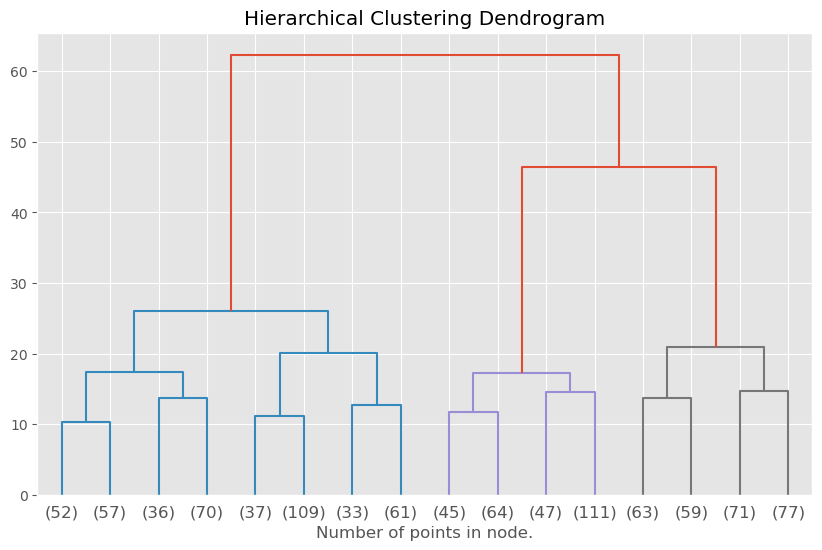

In [41]:
# Assuming the next variables as the features for the clustering algorithm
features = ['mu-logistic-whaling-success', 'whaling-harm-prob', 'theta', 'mutation-prob', 
            '(mean) average-whale-hunt', '(mean) average-help-others']

# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler().fit(dfr_sum[features])
X_scaled = scaler.transform(dfr_sum[features])

# Agglomerative Clustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
model = model.fit(X_scaled)

# Add cluster labels
dfr_sum['cluster_labels'] = cluster_labels

# Create a dendrogram (https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Plot the dendrogram
plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node.")
plt.show()


In [43]:
dfr_sum.groupby('cluster_labels').size()

cluster_labels
0    455
1    270
2    267
dtype: int64

In [48]:
colors = ['tab:green','tab:blue','tab:red','tab:orange','tab:purple','tab:brown']

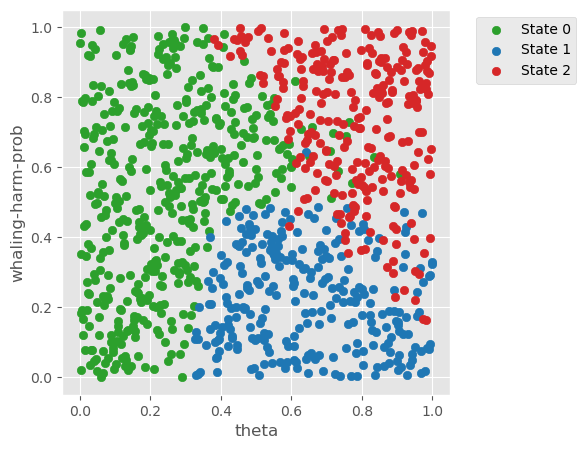

In [42]:
fig=plt.figure(figsize=(5,5))
for state in sorted(dfr_sum['cluster_labels'].unique()):
    plt.scatter(dfr_sum[dfr_sum['cluster_labels'] == state]['theta'],
                dfr_sum[dfr_sum['cluster_labels'] == state]['whaling-harm-prob'],
                color=colors[state],label='State '+str(state))
plt.xlabel('theta')
plt.ylabel('whaling-harm-prob')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

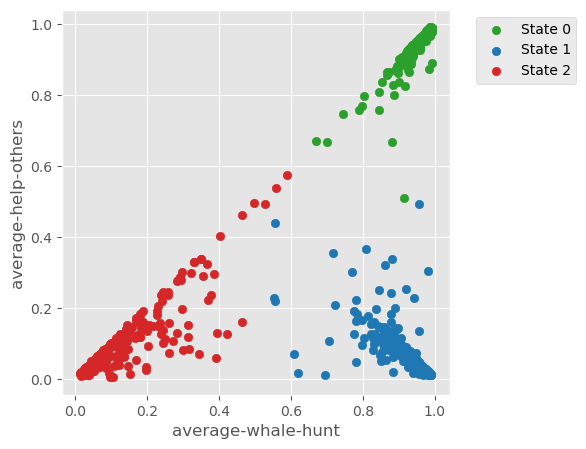

In [50]:
fig=plt.figure(figsize=(5,5))
for state in sorted(dfr_sum['cluster_labels'].unique()):
    plt.scatter(dfr_sum[dfr_sum['cluster_labels'] == state]['(mean) average-whale-hunt'],
                dfr_sum[dfr_sum['cluster_labels'] == state]['(mean) average-help-others'],
                color=colors[state],label='State '+str(state))
plt.xlabel('average-whale-hunt')
plt.ylabel('average-help-others')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Exploratory analysis (deprecated!)

In [7]:
path='..'
dfr=pd.read_csv(path+'/results/stationary_state.csv')

In [8]:
plt.style.use('ggplot')

In [9]:
# Average time series of the last ticks by experiment
dfr_sum=dfr.groupby('experiment').mean()

In [11]:
# Classification of the experiments into deciles of the risk of 'whaling-harm-prob'
dfr_sum['risk_decile'] = pd.qcut(dfr_sum['whaling-harm-prob'], q=10, labels=False)
dfr_sum['risk_quartile'] = pd.qcut(dfr_sum['whaling-harm-prob'], q=4, labels=False)
# Classification of the experiments into deciles of 'theta'
dfr_sum['theta_decile'] = pd.qcut(dfr_sum['theta'], q=10, labels=False)
# Classification of the experiments into deciles of '(mean) average-whale-hunt'
dfr_sum['whale_hunt_decile'] = pd.qcut(dfr_sum['(mean) average-whale-hunt'], q=10, labels=False)
# Classification of the experiments into deciles of '(mean) average-help-others'
dfr_sum['help_others_decile'] = pd.qcut(dfr_sum['(mean) average-help-others'], q=10, labels=False)

In [10]:
dfr_sum.columns

Index(['mu-logistic-whaling-success', 'whaling-harm-prob', 'theta',
       'mutation-prob', 'n-people', '[step]', '(mean) average-whale-hunt',
       '(std) average-whale-hunt', '(mean) average-help-others',
       '(std) average-help-others', '(mean) average-fitness',
       '(std) average-fitness', '(mean) average-resources',
       '(std) average-resources', '(mean) average-social-capital',
       '(std) average-social-capital', '(mean) average-disabled',
       '(std) average-disabled', 'risk_decile', 'risk_quartile',
       'theta_decile'],
      dtype='object')

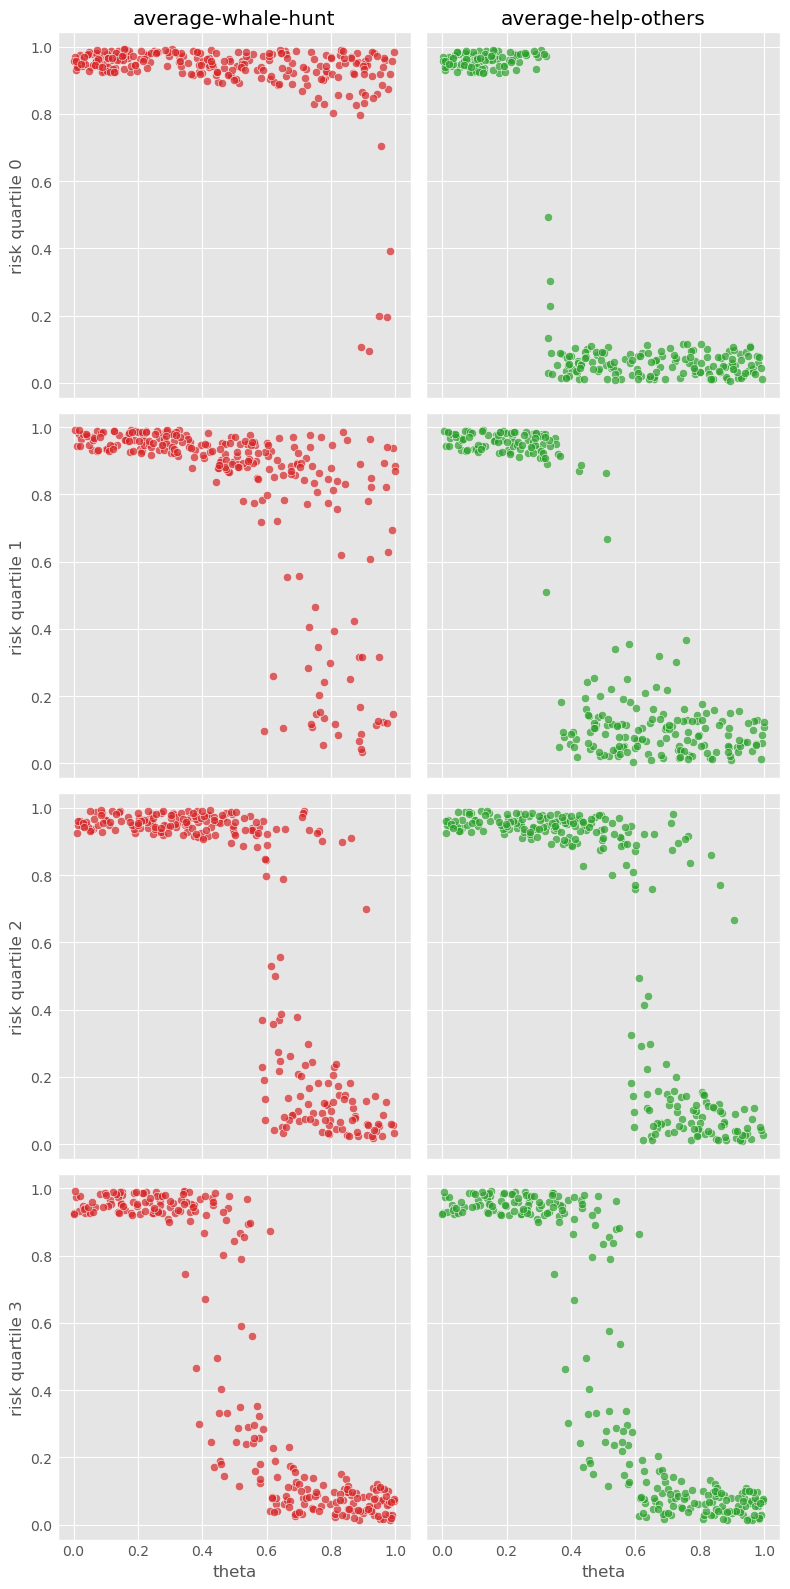

In [92]:
# average-whale-hunt vs. average-help-others by deciles of 'whaling-harm-prob'
fig, axs = plt.subplots(4, 2, figsize=(8, 16), sharex=True, sharey=True)
averages=[(0,'(mean) average-whale-hunt'),(1,'(mean) average-help-others')]
colors=['tab:red', 'tab:green']
for i,variable in averages:
    for j in range(4): # quantiles of 'whaling-harm-prob'
        axs[j, i].scatter(x=dfr_sum[dfr_sum['risk_quartile']==j]['theta'], 
                      y=dfr_sum[dfr_sum['risk_quartile']==j][variable], color=colors[i],edgecolors='white', alpha=0.7)
axs[0, 0].set_title('average-whale-hunt')
axs[0, 1].set_title('average-help-others')
axs[3, 0].set_xlabel('theta')
axs[3, 1].set_xlabel('theta')
for j in range(4):
    axs[j, 0].set_ylabel('risk quartile '+str(j))
fig.tight_layout()
plt.show()

In [12]:
parameters=['theta','whaling-harm-prob','mu-logistic-whaling-success']

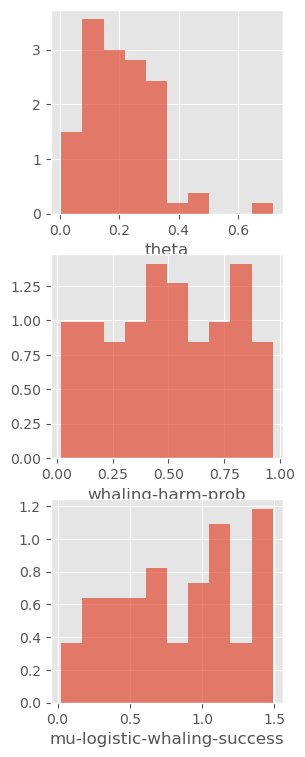

In [17]:
# All cooperation
Dw=9
Dh=9
fig, axs = plt.subplots(len(parameters), 1, figsize=(3, 9))
df_coop=dfr_sum[(dfr_sum['whale_hunt_decile']>=Dw) & (dfr_sum['help_others_decile']>=Dh)]
for i in range(len(parameters)):
    axs[i].hist(df_coop[parameters[i]],density=True, alpha=0.7, label=parameters[i])
    axs[i].set_xlabel(parameters[i]) 
plt.show()

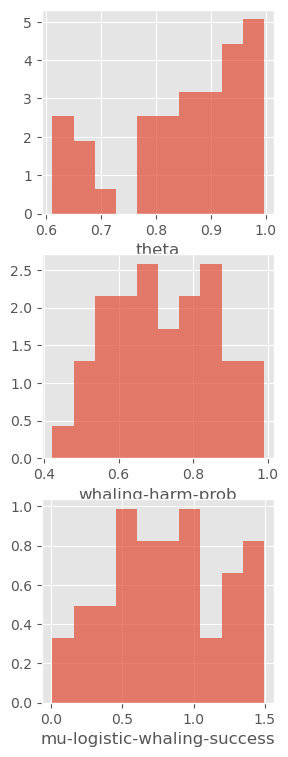

In [20]:
# All defection
Dw=0
Dh=0
fig, axs = plt.subplots(len(parameters), 1, figsize=(3, 9))
df_coop=dfr_sum[(dfr_sum['whale_hunt_decile']<=Dw) & (dfr_sum['help_others_decile']<=Dh)]
for i in range(len(parameters)):
    axs[i].hist(df_coop[parameters[i]],density=True, alpha=0.7, label=parameters[i])
    axs[i].set_xlabel(parameters[i]) 
plt.show()

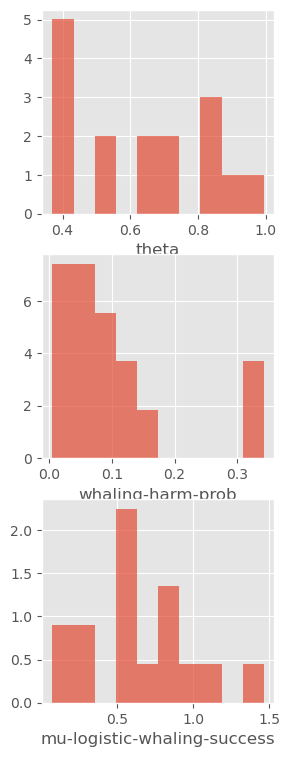

In [13]:
# Only cooperation in whale hunt
Dw=9
Dh=0
fig, axs = plt.subplots(len(parameters), 1, figsize=(3, 9))
df_coop=dfr_sum[(dfr_sum['whale_hunt_decile']>=Dw) & (dfr_sum['help_others_decile']<=Dh)]
for i in range(len(parameters)):
    axs[i].hist(df_coop[parameters[i]],density=True, alpha=0.7, label=parameters[i])
    axs[i].set_xlabel(parameters[i]) 
plt.show()

In [125]:
# Only cooperation in help others: none

In [13]:
dfr_sum['state']=None
dfr_sum.loc[(dfr_sum['whale_hunt_decile']>=9) & (dfr_sum['help_others_decile']>=9),'state']='AC' # All cooperation
dfr_sum.loc[(dfr_sum['whale_hunt_decile']<=0) & (dfr_sum['help_others_decile']<=0),'state']='AD' # All defection
dfr_sum.loc[(dfr_sum['whale_hunt_decile']>=9) & (dfr_sum['help_others_decile']<=0),'state']='OCWH' # Only cooperation in whale hunt
dfr_sum[['state']].groupby('state').size()/dfr_sum[['state']].groupby('state').size().sum()

state
AC      0.568182
AD      0.310606
OCWH    0.121212
dtype: float64

In [19]:
import matplotlib.ticker as ticker

All Cooperation


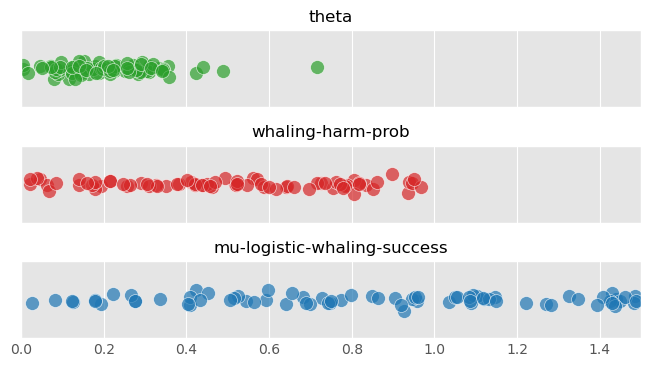

In [28]:
print('All Cooperation')
# Parameter distribution by state
states=('AC','All Cooperation')
# parameters=['theta','whaling-harm-prob','mu-logistic-whaling-success']
colors = ['tab:green', 'tab:red', 'tab:blue']

fig, axs = plt.subplots(len(parameters), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(parameters)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[0],parameters[i]], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=parameters[i])
    axs[i].set_title(parameters[i], fontsize=12)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].set(xlim=(0, 1.5))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
    axs[i].tick_params(axis='x', color='white',direction='in')

plt.subplots_adjust(hspace=0.5)
plt.show()


All Defection


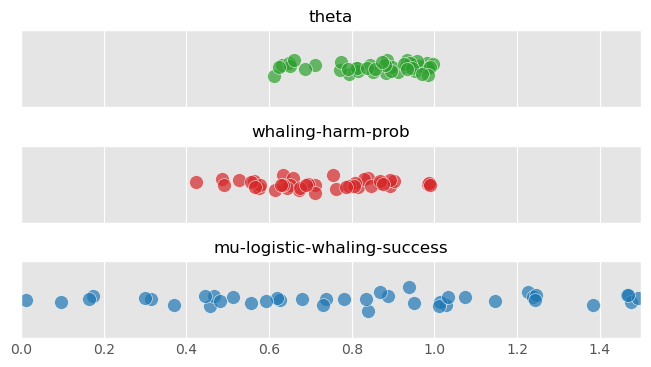

In [29]:
print('All Defection')
# Parameter distribution by state
states=('AD','All Defection')
# parameters=['theta','whaling-harm-prob','mu-logistic-whaling-success']
colors = ['tab:green', 'tab:red', 'tab:blue']

fig, axs = plt.subplots(len(parameters), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(parameters)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[0],parameters[i]], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=parameters[i])
    axs[i].set_title(parameters[i], fontsize=12)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].set(xlim=(0, 1.5))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
    axs[i].tick_params(axis='x', color='white',direction='in')

plt.subplots_adjust(hspace=0.5)
plt.show()


Only Cooperation in Whale Hunt


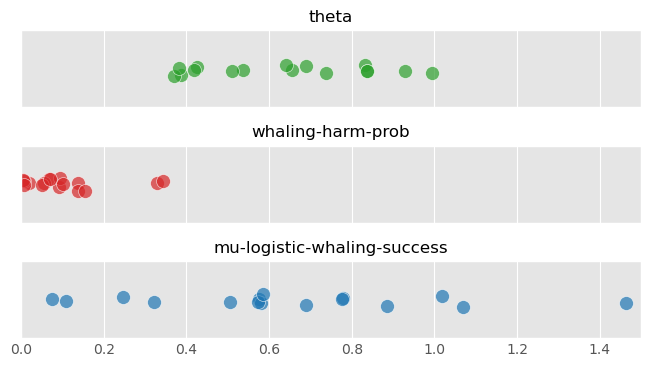

In [30]:
print('Only Cooperation in Whale Hunt')
# Parameter distribution by state
states=('OCWH','Only Cooperation in Whale Hunt')
# parameters=['theta','whaling-harm-prob','mu-logistic-whaling-success']
colors = ['tab:green', 'tab:red', 'tab:blue']

fig, axs = plt.subplots(len(parameters), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(parameters)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[0],parameters[i]], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=parameters[i])
    axs[i].set_title(parameters[i], fontsize=12)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].set(xlim=(0, 1.5))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
    axs[i].tick_params(axis='x', color='white',direction='in')

plt.subplots_adjust(hspace=0.5)
plt.show()

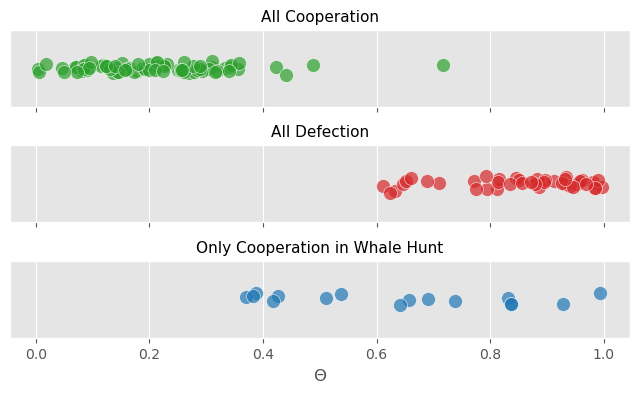

In [33]:
# Distribution of 'theta' by state
states=[('AC','All Cooperation'),('AD','All Defection'),('OCWH','Only Cooperation in Whale Hunt')]
colors = ['tab:green', 'tab:red', 'tab:blue']
fig, axs = plt.subplots(len(states), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(states)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[i][0],'theta'], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[i][0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=states[i][0])
    axs[i].set_title(states[i][1], fontsize=11)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
axs[len(states)-1].set_xlabel(r'$\Theta$')
plt.subplots_adjust(hspace=0.5)
plt.show()

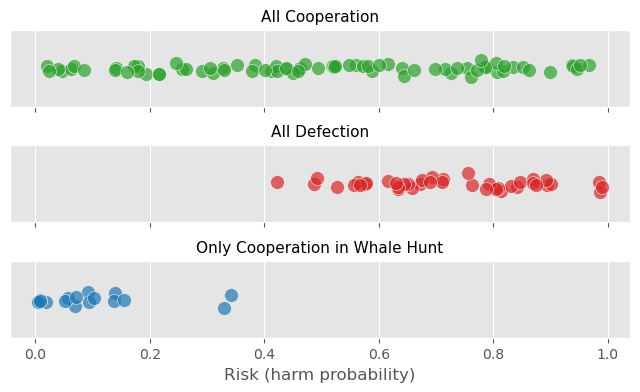

In [34]:
# Distribution of 'whaling-harm-prob' by state
states=[('AC','All Cooperation'),('AD','All Defection'),('OCWH','Only Cooperation in Whale Hunt')]
colors = ['tab:green', 'tab:red', 'tab:blue']
fig, axs = plt.subplots(len(states), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(states)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[i][0],'whaling-harm-prob'], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[i][0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=states[i][0])
    axs[i].set_title(states[i][1], fontsize=11)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
axs[len(states)-1].set_xlabel('Risk (harm probability)')
plt.subplots_adjust(hspace=0.5)
plt.show()

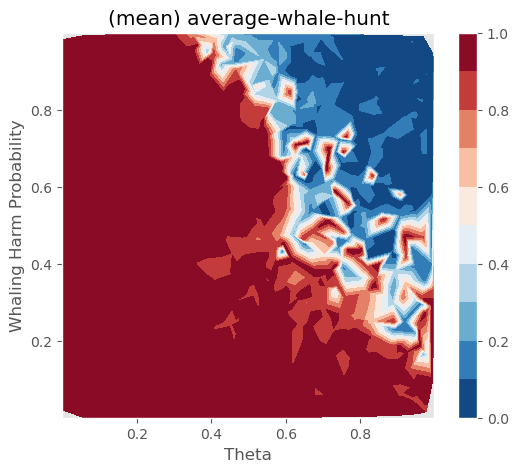

In [47]:
# Average whale hunt by 'theta' and 'whaling-harm-prob'
plt.figure(figsize=(6, 5))
plt.tricontourf(dfr_sum['theta'], dfr_sum['whaling-harm-prob'], dfr_sum['(mean) average-whale-hunt'], 
                levels=10, cmap='RdBu_r',vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Theta')
plt.ylabel('Whaling Harm Probability')
plt.title('(mean) average-whale-hunt')
plt.show()

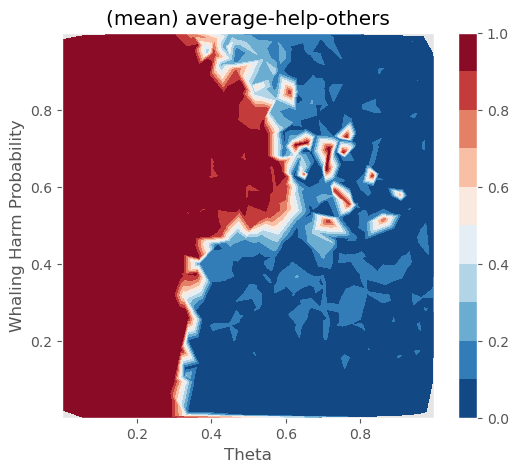

In [48]:
# Average help others by 'theta' and 'whaling-harm-prob'
plt.figure(figsize=(6, 5))
plt.tricontourf(dfr_sum['theta'], dfr_sum['whaling-harm-prob'], dfr_sum['(mean) average-help-others'], 
                levels=10, cmap='RdBu_r',vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Theta')
plt.ylabel('Whaling Harm Probability')
plt.title('(mean) average-help-others')
plt.show()